In [1]:
import exoplanet
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import arviz as az
from astropy import constants as c
from astropy import units as un
import matplotx
import scienceplots

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


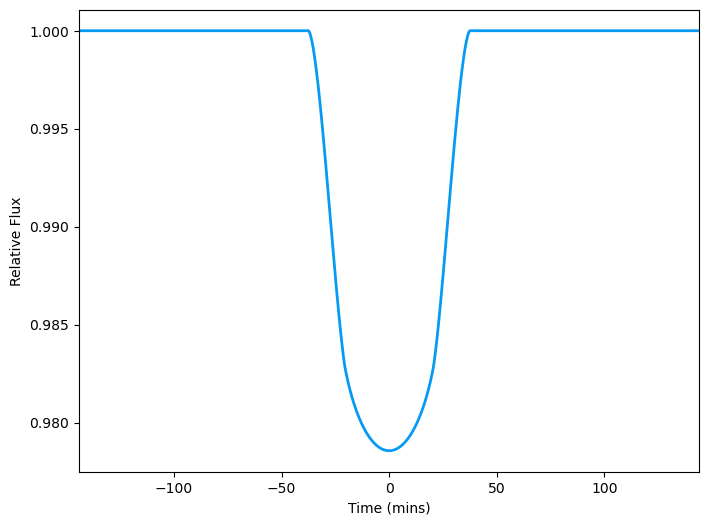

In [2]:
# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=0.813475, b=0.698, r_star=0.667, m_star=0.58)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.6012, 0.1492]
light_curve = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=0.095569297, t=t)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background
plt.figure(figsize = (8,6))
t = t*24*60
plt.plot(t, 1 + light_curve, color="xkcd:azure", lw=2)
plt.ylabel("Relative Flux")
plt.xlabel("Time (mins)")
_ = plt.xlim(t.min(), t.max())

In [6]:
data = np.load("data.npy")
ts = data[:,0]
t_start = ts[0]
ts = ts - ts[0]
ys = data[:,1]
yerrs = data[:,2]
tmin = ts*60*24

In [7]:
np.mean(yerrs)

0.003630533981998593

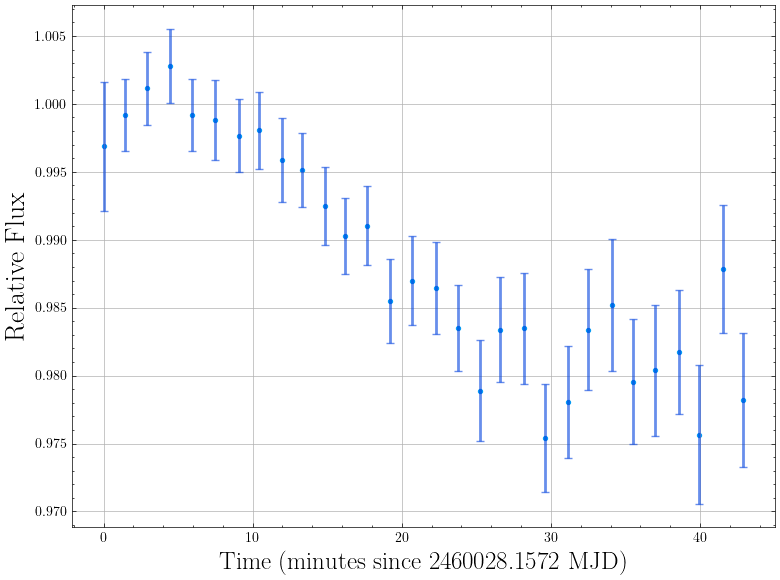

In [8]:
plt.style.use('science')
plt.figure(figsize = (8,6))
plt.scatter(tmin,ys,s=8, c='xkcd:azure')
plt.errorbar(tmin,ys,yerr = yerrs,capsize=3,ls='none', c='xkcd:blue',lw=2,alpha = 0.6)
plt.ylabel("Relative Flux",fontsize = 20)
plt.xlabel(f"Time (minutes since {t_start.round(4)} MJD)",fontsize = 18)
# plt.xlim(0,ts[-1]+5)
# _ = plt.title("WASP-43b Raw Transit Light Curve")
plt.tight_layout()
plt.grid()
plt.savefig("./report/images/raw.pdf")

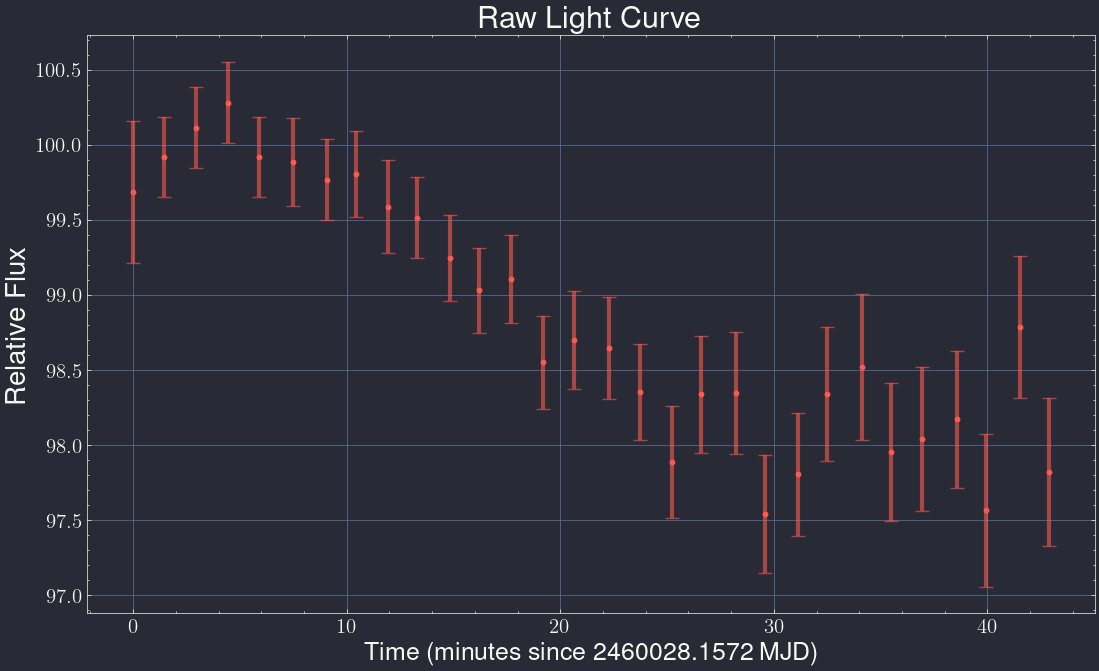

In [93]:
plt.style.use(matplotx.styles.dracula)
fig = plt.figure(figsize = (13,10/16*12))
plt.scatter(tmin,100*ys,s=10, c='xkcd:coral')
plt.errorbar(tmin,100*ys,yerr = 100*yerrs,capsize=5,ls='none', c='xkcd:coral',lw=3,alpha = 0.6)
plt.ylabel("Relative Flux",fontsize = 20)
plt.xlabel(f"Time (minutes since {t_start.round(4)} MJD)",fontsize = 18)
# plt.xlim(0,ts[-1]+5)
_ = plt.title("Raw Light Curve",fontsize = 22)
# plt.tight_layout()
plt.grid()
plt.savefig("./report/images/raw2.png")

In [9]:
np.random.seed(123)
periods = 0.813477
t0s = 45/60/24
t = ts
yerr = np.mean(yerrs)

In [122]:
with pm.Model() as model:
    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=0.5)

    # The time of a reference transit for each planet
    t0 = pm.Normal(r"$T_{mid}$", mu=t0s, sd=1/24)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(0.9), sd=0.2,testval = np.log(0.813477)) #change sd to 1?
    period = pm.Deterministic(r"$T_{orb}$", pm.math.exp(logP))
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = [0.6012, 0.1492]

    r = pm.Uniform(
        r"$R_p$", lower=0.06, upper=0.12, testval=0.095569297
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, testval=0.698
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=0.667, m_star=0.58)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

#     # ******************************************************************* #
#     # On the folowing lines, we simulate the dataset that we will fit     #
#     #                                                                     #
#     # NOTE: if you are fitting real data, you shouldn't include this line #
#     #       because you already have data!                                #
#     # ******************************************************************* #
#     y = pmx.eval_in_model(light_curve)
#     y += yerr * np.random.randn(len(y))
#     # ******************************************************************* #
#     # End of fake data creation; you want to include the following lines  #
#     # ******************************************************************* #

    y = ys
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = pmx.optimize(start=model.test_point)

IndexError: index out of bounds

In [11]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=10000,
        start=map_soln,
        cores=1,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Sequential sampling (2 chains in 1 job)
NUTS: [b, $R_p$, logP, $T_{mid}$, mean]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 165 seconds.
The acceptance probability does not match the target. It is 0.8336115440671683, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
summ = az.summary(trace, var_names=[r"$T_{orb}$", r"$T_{mid}$", r"$R_p$", "b","mean"])
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$T_{orb}$,0.923,0.186,0.605,1.275,0.007,0.005,817.0,2453.0,1.00
$T_{mid}$,0.034,0.005,0.025,0.041,0.000,0.000,253.0,356.0,1.01
$R_p$,0.089,0.007,0.079,0.107,0.001,0.001,147.0,53.0,1.01
b,0.501,0.261,0.055,0.895,0.016,0.015,121.0,41.0,1.01
mean,0.999,0.001,0.997,1.002,0.000,0.000,3763.0,5204.0,1.00


In [13]:
tmin = ts*24*60

In [14]:
fitted = summ[:]["mean"]
fitted

$T_{orb}$    0.923
$T_{mid}$    0.034
$R_p$        0.089
b            0.501
mean         0.999
Name: mean, dtype: float64

In [15]:
sd = summ[:]["sd"]

In [16]:
t = fitted[r"$T_{orb}$"]*un.d
m_s = 0.58*c.M_sun
a = (c.G*m_s/(4*np.pi**2))**(1/3)*t**(2/3)
a = a.to(un.meter)
(0.667*c.R_sun)/a

<Quantity 0.20048301>

In [17]:
np.arccos((0.667*c.R_sun)/a * fitted['b']).to(un.deg).value

84.23537727635714

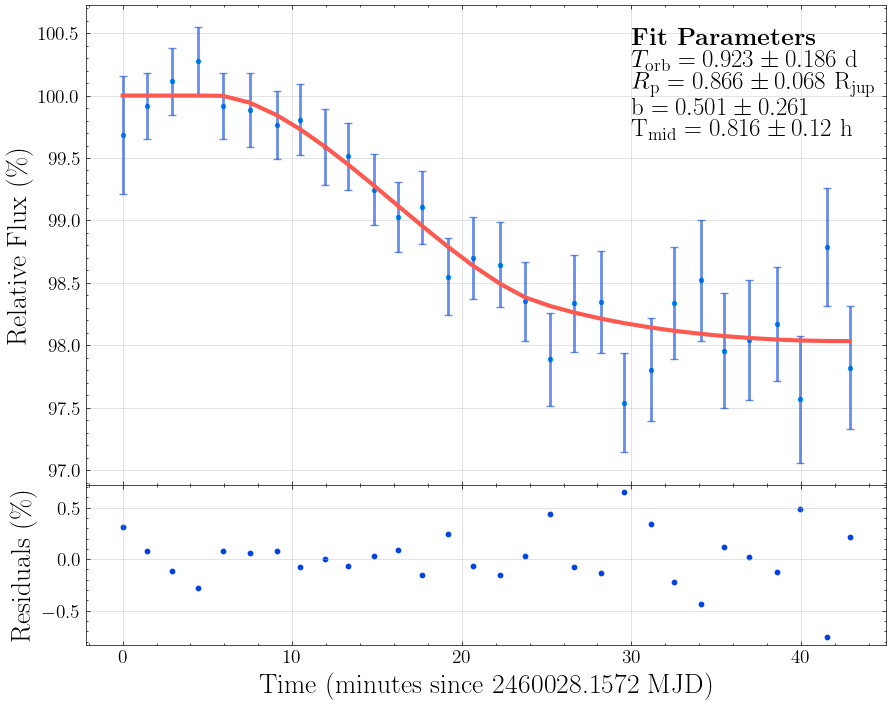

In [60]:
plt.style.use('default')
plt.style.use('science')
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
fig = plt.figure(figsize = (10,8))
frame1=fig.add_axes((.1,.3,.8,.6))
plt.scatter(tmin,ys*100,s=8, c='xkcd:azure')
plt.errorbar(tmin,100*ys,yerr = yerrs*100,capsize=3,ls='none', c='xkcd:blue',lw=2,alpha = 0.6)
plt.plot(tmin, 100*(1+map_soln["light_curves"][:, 0]), lw=3, c = 'xkcd:coral')
# _ = plt.title("WASP-43b Fitted Transit Light Curve",fontsize = 18)
frame1.set_xticklabels([])
# plt.xlim(t.min(), t.max())
plt.ylabel("Relative Flux (\%)",fontsize = 20)
plt.grid(alpha = 0.5)
frame2=fig.add_axes((.1,.1,.8,.2))        
plt.scatter(tmin, (1+map_soln["light_curves"][:, 0]-ys)/ys*100, c='xkcd:blue',s=10)
plt.xlabel(f"Time (minutes since {t_start.round(4)} MJD)",fontsize = 20)
plt.ylabel("Residuals (\%)",fontsize = 20)
plt.text(
    30,5.00,r"\noindent \textbf{{Fit Parameters}} \vspace{{3pt}} \\ $T_{{\mathrm{{orb}}}} = {} \pm {} \ \mathrm{{d}}  $ \\ $ R_{{\mathrm{{p}}}} = {} \pm {} \ \mathrm{{ R_{{\mathrm{{jup}}}}}} $\\ $ \mathrm{{b}} = {} \pm {}$ \\ $ \mathrm{{T_{{mid}}}} = {} \pm {} \ \mathrm{{h}}$".format(
        fitted[r"$T_{orb}$"],sd[r"$T_{orb}$"],(fitted[r"$R_p$"]*c.R_sun/c.R_jup).round(3),(sd[r"$R_p$"]*c.R_sun/c.R_jup).round(3),fitted['b'].round(3),sd['b'].round(3),(24*fitted['$T_{mid}$']).round(3),(24*sd['$T_{mid}$']).round(3)), 
    fontsize = 18
);
plt.grid(alpha = 0.5)
plt.savefig("./report/images/fit.pdf",dpi=200)
# print(ax.get_ylim())
# plt.xlim(0,ts[-1]+5)


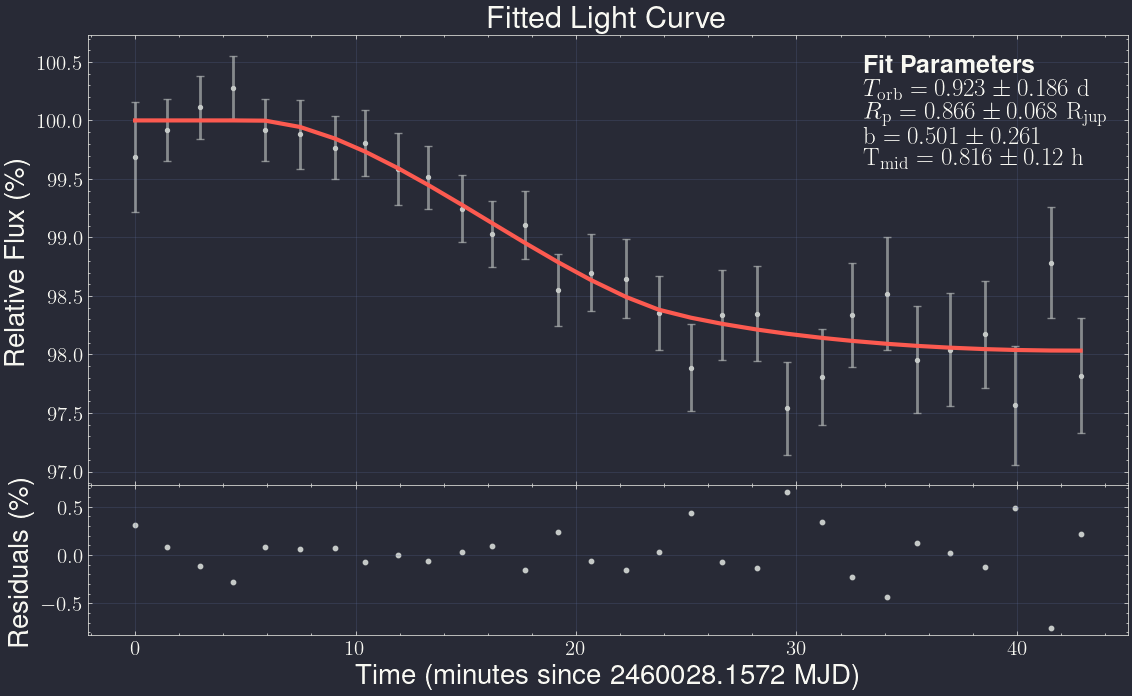

In [85]:
plt.style.use(matplotx.styles.dracula)

fig = plt.figure(figsize = (13,10/16*12))
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
frame1=fig.add_axes((.1,.3,.8,.6))
plt.scatter(tmin,ys*100,s=8, c='xkcd:silver')
plt.errorbar(tmin,100*ys,yerr = yerrs*100,capsize=3,ls='none', c='xkcd:silver',lw=2,alpha = 0.6)
plt.plot(tmin, 100*(1+map_soln["light_curves"][:, 0]), lw=3, c = 'xkcd:coral')
_ = plt.title("Fitted Light Curve",fontsize = 22)
frame1.set_xticklabels([])
# plt.xlim(t.min(), t.max())
plt.ylabel("Relative Flux (\%)",fontsize = 20)
plt.grid(alpha = 0.3)
frame2=fig.add_axes((.1,.1,.8,.2))        
plt.scatter(tmin, (1+map_soln["light_curves"][:, 0]-ys)/ys*100, c='xkcd:silver',s=10)
plt.xlabel(f"Time (minutes since {t_start.round(4)} MJD)",fontsize = 20)
plt.ylabel("Residuals (\%)",fontsize = 20)
plt.text(
    33,5.00,r"\noindent \textbf{{Fit Parameters}} \vspace{{3pt}} \\ $T_{{\mathrm{{orb}}}} = {} \pm {} \ \mathrm{{d}}  $ \\ $ R_{{\mathrm{{p}}}} = {} \pm {} \ \mathrm{{ R_{{\mathrm{{jup}}}}}} $\\ $ \mathrm{{b}} = {} \pm {}$ \\ $ \mathrm{{T_{{mid}}}} = {} \pm {} \ \mathrm{{h}}$".format(
        fitted[r"$T_{orb}$"],sd[r"$T_{orb}$"],(fitted[r"$R_p$"]*c.R_sun/c.R_jup).round(3),(sd[r"$R_p$"]*c.R_sun/c.R_jup).round(3),fitted['b'].round(3),sd['b'].round(3),(24*fitted['$T_{mid}$']).round(3),(24*sd['$T_{mid}$']).round(3)), 
    fontsize = 18
);
plt.grid(alpha = 0.3)
plt.savefig("./report/images/fit2.png",dpi=200)
# print(ax.get_ylim())
# plt.xlim(0,ts[-1]+5)

In [19]:
np.std(1+map_soln["light_curves"][:, 0]-ys)*100

0.2676064781831612

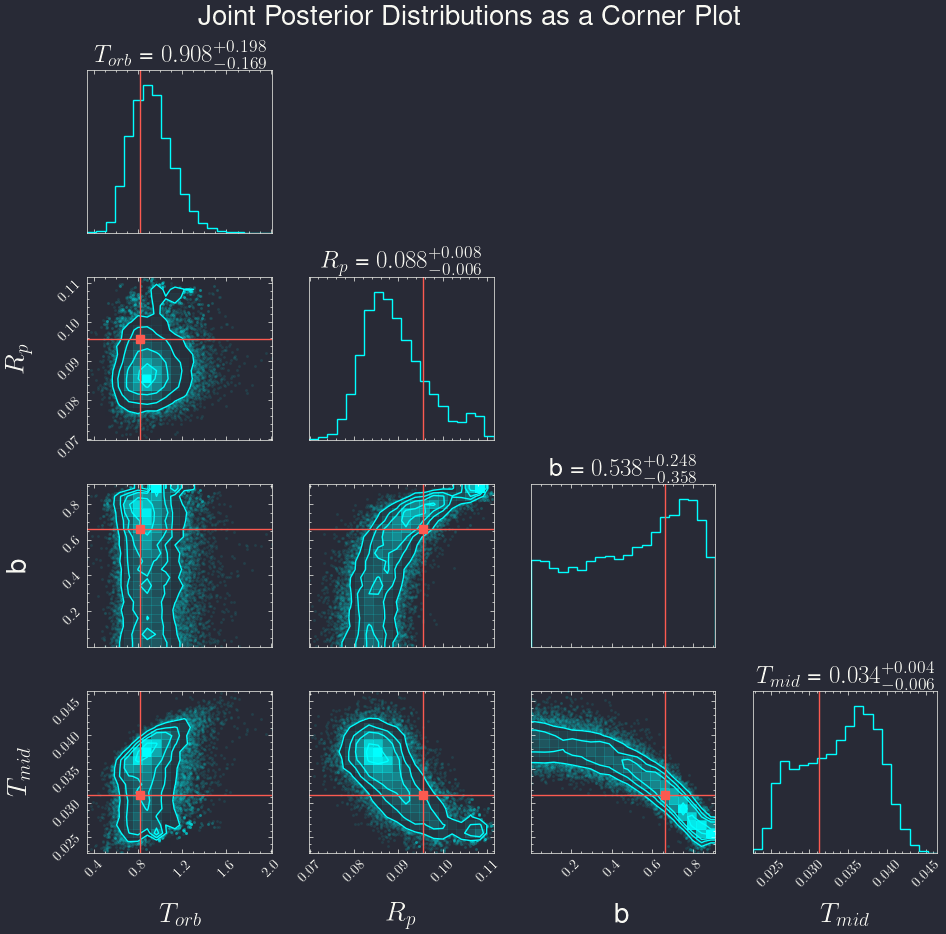

In [104]:
import corner
plt.style.use(matplotx.styles.dracula)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams.update({"axes.labelsize" : 20,"axes.titlesize" : 18})
# truth = dict(
#     zip(
#         [r"$T_{orb}$", r"$R_p$","b",r"$T_{mid}$"],
#         pmx.eval_in_model([period, r,b,t0], model.test_point, model=model),
#     )
# )
truth = dict(
    zip(
        [r"$T_{orb}$", r"$R_p$","b",r"$T_{mid}$"],
         [0.813,0.93*c.R_jup/c.R_sun,0.66,45/24/60],
    )
)
_ = corner.corner(
    trace,
    var_names=[r"$T_{orb}$", r"$R_p$","b",r"$T_{mid}$"],
    truths=truth,
    show_titles=True,
    color = "xkcd:cyan",
    title_fmt='.3f',
    truth_color='xkcd:coral'
#     smooth = 1
)
plt.suptitle("Joint Posterior Distributions as a Corner Plot",fontsize = 20)
plt.tight_layout()
plt.savefig("./report/images/corner2.png")

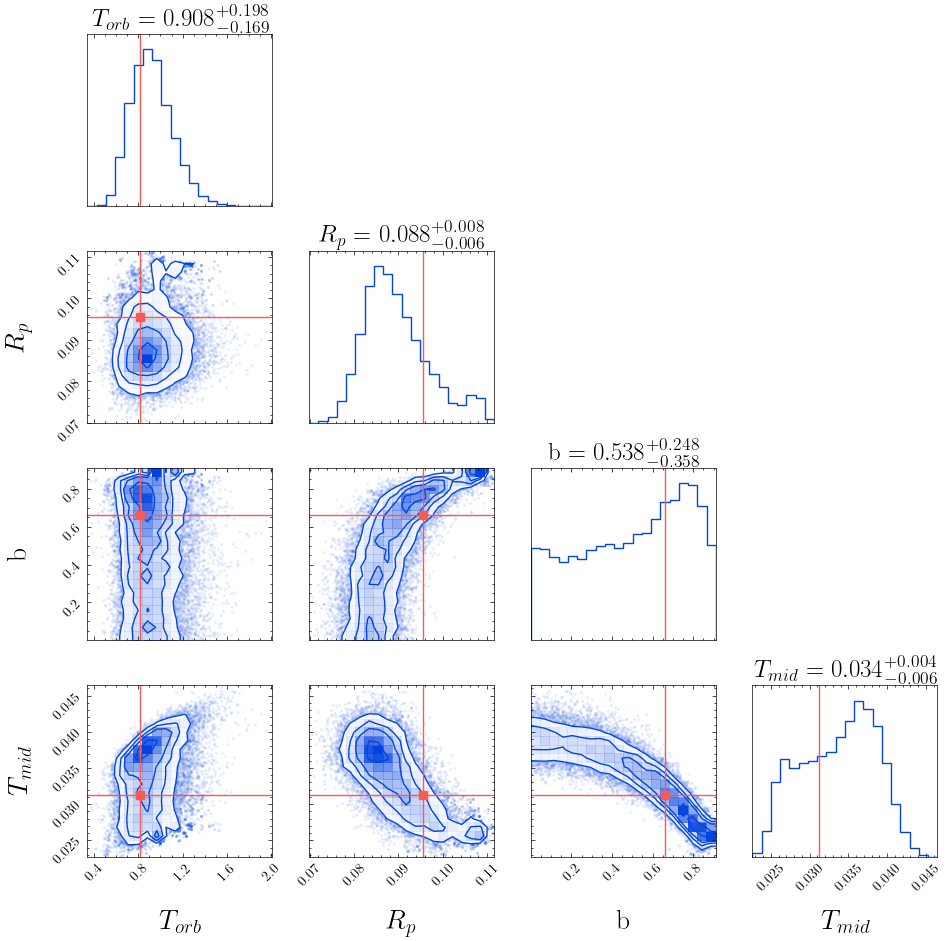

In [99]:
import corner
plt.style.use("default")
plt.style.use("science")
plt.rcParams.update({"axes.labelsize" : 20,"axes.titlesize" : 18})
# truth = dict(
#     zip(
#         [r"$T_{orb}$", r"$R_p$","b",r"$T_{mid}$"],
#         pmx.eval_in_model([period, r,b,t0], model.test_point, model=model),
#     )
# )
truth = dict(
    zip(
        [r"$T_{orb}$", r"$R_p$","b",r"$T_{mid}$"],
         [0.813,0.93*c.R_jup/c.R_sun,0.66,45/24/60],
    )
)
_ = corner.corner(
    trace,
    var_names=[r"$T_{orb}$", r"$R_p$","b",r"$T_{mid}$"],
    truths=truth,
    show_titles=True,
    color = "xkcd:blue",
    title_fmt='.3f',
    truth_color='xkcd:coral'
#     smooth = 1
)
plt.tight_layout()
plt.savefig("./report/images/corner.pdf")

<Axes: title={'center': '$T_{orb}$'}>

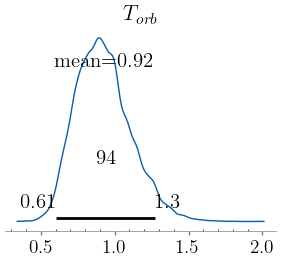

In [106]:
plt.style.use("default")
plt.style.use("science")
az.plot_posterior(trace, var_names=[r"$T_{orb}$"])

In [129]:
with pm.Model() as mod:
    logP1 = pm.Normal("logP1", mu=np.log(0.9), sd=0.2,testval = np.log(0.813477))
    period1 = pm.Deterministic(r"$T_{orb}$", pm.math.exp(logP1))
    trace = pm.sample(10000)

C:\Users\advai\AppData\Local\Temp\ipykernel_21268\4183028417.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logP1]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 29 seconds.


In [130]:
aaa = trace[r"$T_{orb}$"]

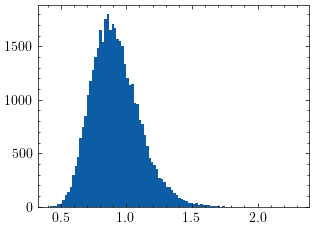

In [132]:
plt.hist(aaa,bins=100);

In [124]:
pm.draw(period,100)

ModuleNotFoundError: No module named 'pymc'

In [111]:
az.plot_ppc(trace, var_names=[r"$T_{orb}$"])

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

In [116]:
period.draw()

AttributeError: 'DeterministicWrapper' object has no attribute 'draw'

In [32]:
plt.style.use("default")
plt.style.use("science")

In [40]:
0.006*60*24

8.64

In [21]:
truth

{'$T_{orb}$': array(0.813477),
 '$R_p$': array(0.0955693),
 'b': array(0.698),
 '$T_{mid}$': array(0.03125)}

In [22]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [291]:
stacked = az.extract(trace)
stacked.period.values

array([0.99080772, 0.79043386, 0.75398532, ..., 0.75568752, 0.98892405,
       0.89218774])

In [300]:
trace.posterior.loc[dict(chain=[0, 1],draw = 100)]

<xarray.Dataset>
Dimensions:             (chain: 2, light_curves_dim_0: 30, light_curves_dim_1: 1)
Coordinates:
  * chain               (chain) int32 0 1
    draw                int32 100
  * light_curves_dim_0  (light_curves_dim_0) int32 0 1 2 3 4 ... 25 26 27 28 29
  * light_curves_dim_1  (light_curves_dim_1) int32 0
Data variables:
    mean                (chain) float64 0.9996 0.997
    t0                  (chain) float64 0.03498 0.03158
    logP                (chain) float64 -0.2417 -0.2552
    period              (chain) float64 0.7853 0.7748
    r                   (chain) float64 0.08148 0.08307
    b                   (chain) float64 0.3716 0.6489
    light_curves        (chain, light_curves_dim_0, light_curves_dim_1) float64 ...
Attributes:
    created_at:                 2023-04-25T21:58:50.678682
    arviz_version:              0.13.0
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              126.42823696136475
    tuning_steps:               1000

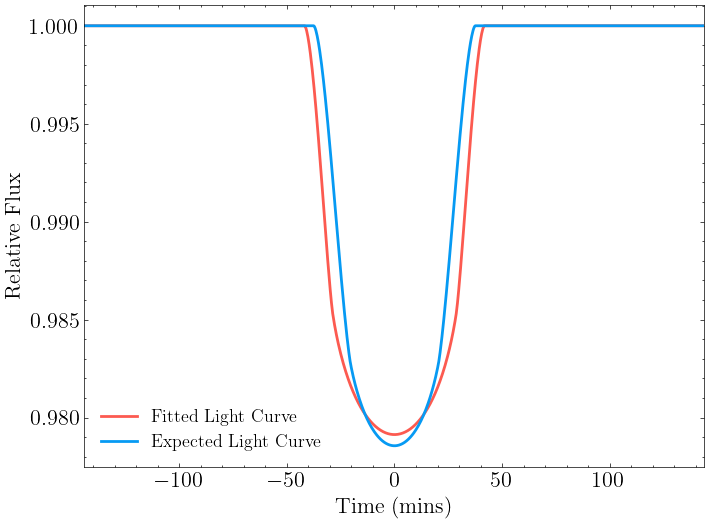

In [428]:
# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=fitted["period"], b=fitted['b'], r_star=0.667, m_star=0.58)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.6012, 0.1492]
light_curve = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=fitted['r'], t=t)
    .eval()
)

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=0.813475, b=0.698, r_star=0.667, m_star=0.58)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.6012, 0.1492]
light_curve2 = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=0.095569297, t=t)
    .eval()
)

plt.figure(figsize = (8,6))
t = t*24*60
plt.plot(t, 1 + light_curve, lw=2, color="xkcd:coral", label = "Fitted Light Curve")
plt.plot(t, 1 + light_curve2, lw=2, color="xkcd:azure", label = "Expected Light Curve")
plt.ylabel("Relative Flux")
plt.xlabel("Time (mins)")
plt.legend(fontsize=13)
_ = plt.xlim(t.min(), t.max())